In [1]:
import os

import tensorflow as tf
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import time

In [2]:
video_name = 'observation088' 
animal_type = 'GZ'

processed_folder = '/media/golden/72FFC6EE48B5CF39/drone-tracking/kenya-tracking/processed-videos/raw-footage/' + video_name 

tracks_file = '/media/golden/72FFC6EE48B5CF39/drone-tracking/kenya-tracking/processed-videos/raw-footage/' + video_name + '/localizations/tracks-complete.npy'
save_path = '/media/golden/72FFC6EE48B5CF39/drone-tracking/kenya-tracking/processed-videos/raw-footage/' + video_name + '/track-images-demo/'
tfrecords_folder = '/media/golden/72FFC6EE48B5CF39/drone-tracking/kenya-tracking/raw-frames-tfrecords/raw-footage/raw-footage/' + video_name

 


save_frames = True

box_size = 160



tracks_list = np.load(tracks_file)

tfrecords_list = glob.glob(tfrecords_folder + '/*')
tfrecords_list.sort()
tfrecords_list = tfrecords_list[:1]


if not os.path.isdir(save_path):
    os.mkdir(save_path)


print('using ', len(tfrecords_list), 'files')
print('demo file:', tfrecords_list[0])


using  1 files
demo file: /media/golden/72FFC6EE48B5CF39/drone-tracking/kenya-tracking/raw-frames-tfrecords/raw-footage/raw-footage/observation088/train-00000-of-00040


In [3]:
from queue import Queue
from threading import Thread
import sys
import time
if save_frames:
    class VideoWriter:
        def __init__(self, queue_size=100, timeout=3, frame_width=0, frame_height=0, video_out_file=None):
            # initialize the file video stream along with the boolean
            # used to indicate if the thread should be stopped or not
            self.queue_size = queue_size
            self.timeout = timeout
            self.stopped = False
            self.frame_width = frame_width
            self.frame_height = frame_height
            # initialize the queue used to store frames read from
            # the video file
            self.Q = Queue(maxsize=queue_size)
            self.video_out_file = video_out_file

        def start(self):

    #         fourcc = cv2.VideoWriter_fourcc(*'mjpg')
    #         self.out = cv2.VideoWriter(filename=self.video_out_file, fourcc=fourcc, fps=30, 
    #                               frameSize=(frame_width, frame_height), isColor=True)
            # start a thread to read frames from the file video stream
            self.t = Thread(target=self.write, args=())
            self.t.daemon = True
            self.t.start()
            time.sleep(1)
            return self

        def write(self):
            # keep looping infinitely
            while True:
                # if the thread indicator variable is set, stop the
                # thread
                if self.stopped:
                    return

                # otherwise, ensure the queue has room in it
                if not self.Q.empty():
                    frame, frame_file = self.Q.get()
    #                 self.out.write(frame)
#                     file_name = os.path.basename(frame_file)
#                     frame_new_file = os.path.join(self.video_out_file, file_name)
                    cv2.imwrite(frame_file, frame)
                    # add the frame to the queue
                else:
                    time.sleep(self.timeout)

        def add_frame(self, frame):
            self.Q.put(frame)



        def flush(self):
            while not self.Q.empty():
    #             frame = self.Q.get()
    #             self.out.write(frame)
                frame, frame_file = self.Q.get()
    #                 self.out.write(frame)
                file_name = os.path.basename(frame_file)
                frame_new_file = os.path.join(self.video_out_file, file_name)
                cv2.imwrite(frame_new_file, frame)

        def stop(self):
            # indicate that the thread should be stopped
            print('stopping')
            self.stopped = True
            self.t.join()
            self.flush()
    #         self.out.release()

        def close(self):
            self.stop()

In [4]:
if save_frames:
    video_writer = VideoWriter(frame_width=box_size, frame_height=box_size, video_out_file=save_path)
    video_writer.start()
    print('starting video writer')

starting video writer


In [5]:
with tf.Session() as sess:
    
    
    
    def save_frame(extracts, frame_count, frames_path, video_writer):
        
        tail = 'frame_'
        
        for extract_ind, extract in enumerate(extracts):
            if extract is None:
                continue
            new_tail = tail + ('{1:02d}_{0:05d}.jpg').format(frame_count, extract_ind)
            track_folder = os.path.join(frames_path, str(extract_ind))
            if not os.path.exists(track_folder):
                os.mkdir(track_folder)
            new_image_file = os.path.join(track_folder, new_tail)

            extract = cv2.cvtColor(extract, cv2.COLOR_BGR2RGB)
            video_writer.add_frame([extract, new_image_file])

    
    
    def extract_crops(frame, frame_num, tracks, box_size):
        
        full_width = frame.shape[1]
        scale = frame.shape[1] / full_width
        extracts = []
        for track_ind, track in enumerate(tracks):
            if track['first_frame'] > frame_num:
                extracts.append(None)
                continue
            if track['last_frame'] < frame_num:
                extracts.append(None)
                continue
            rel_frame = frame_num - track['first_frame']

            box_size = box_size * scale
            center = track['track'][rel_frame] * scale

            box = [[] for _ in range(4)]
            box[0] = int(frame.shape[0] - center[0] - box_size / 2)
            box[1] = int(center[1] - box_size / 2)
            box[2] = int(frame.shape[0] - center[0] + box_size / 2)
            box[3] = int(center[1] + box_size / 2)
            
            extracts.append(frame[box[0]:box[2], box[1]:box[3]])
                    
# #                 cv2.rectangle(frame, (int(box[1]), int( box[0])), (int(box[3]), int( box[2])), (0,0,255), 2) 
#             elif draw_tracks:
#                 track_xy = np.hstack([-track['track'][frame_num-rel_track_length:frame_num,1:], track['track'][frame_num-rel_track_length:frame_num,0:1]])
#                 for step in range(rel_track_length):
#                     track_xy[step] = cv2.perspectiveTransform(np.expand_dims(track_xy[step:step+1].astype(np.float32), 0), net_movement[step])
#                     track_xy[step] = np.hstack([track_xy[step,1:], -track_xy[step,0:1]])
#                     cv2.circle(frame, (int(track_xy[step][1] * scale), frame.shape[0] - int(track_xy[step][0] * scale)),
#                        dot_size, colors[track_ind], -1)
            
#             else:
#                 cv2.circle(frame, (int(track['track'][rel_frame][1] * scale), frame.shape[0] - int(track['track'][rel_frame][0] * scale)),
#                        dot_size, (0,0,255), -1)
        return extracts

        
    dataset = tf.data.TFRecordDataset(tfrecords_list)
#     raw_width = 4096
#     raw_height = 2160
#     downsampling = 2

    def _parse_tf_record(example_proto):

        downsampling = 1


        features = {
            'image/height': tf.FixedLenFeature((), tf.int64),
            'image/width': tf.FixedLenFeature((), tf.int64),
            'image/colorspace': tf.FixedLenFeature((), tf.string),
            'image/channels': tf.FixedLenFeature((), tf.int64),
            'image/format': tf.FixedLenFeature((), tf.string),
            'image/filename':tf.FixedLenFeature((), tf.string),
            'image/encoded': tf.FixedLenFeature([], tf.string)}
        parsed_features = tf.parse_single_example(example_proto, features)
        
        image = tf.image.decode_jpeg(
          parsed_features['image/encoded'], channels=3, ratio=downsampling)

        return image

    batch_size = 64
    dataset = dataset.map(_parse_tf_record, num_parallel_calls=2)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(1)

    iterator = dataset.make_one_shot_iterator()
    next_image = iterator.get_next()
    
        
    batch_num = 0
    last_frame = None
    frame_count = 0
    speed_factor = 3
    t0 = time.time()
    while True:
        try:
            if batch_num % 10 == 0:
                print('frame count: ', batch_num * batch_size)
            frame_batch = sess.run(next_image)
            for frame_ind in range(frame_batch.shape[0]):
                if frame_count % speed_factor == 0:
                    im = frame_batch[frame_ind]
                    extracts = extract_crops(im, frame_count, tracks_list, box_size)
                    if frame_count % speed_factor == 0:
                        save_frame(extracts, int(frame_count/4), save_path, video_writer)
                frame_count += 1
            last_frame = frame_batch[-1]
            batch_num += 1
        except tf.errors.OutOfRangeError:
            break
    print('time:', time.time() - t0)


frame count:  0
frame count:  640
frame count:  1280
frame count:  1920
time: 83.40666580200195


In [9]:
warps[100]

array([[ 9.99958333e-01,  6.16519452e-05,  2.56160004e-03],
       [-6.16519452e-05,  9.99958333e-01,  8.59596186e-02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [7]:
print(len(warps))
warps[0]
batch_num

9819


154

In [ ]:
cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
 
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
 
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

In [12]:
print(len(warps))
print(total_warp)
raw_height = im1.shape[0]
raw_width = im1.shape[1]
cos = np.abs(total_warp[0,0])
sin = np.abs(total_warp[0,1])
nW = int((raw_height * sin) + (raw_width * cos))
nH = int((raw_height * cos) + (raw_width * sin))
print(raw_height, raw_width)

2393
[[ 1.01322827e+00  8.67568503e-02  8.97530556e+02]
 [-8.67568503e-02  1.01322827e+00  1.29067584e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
1080 2048


To create a video, run the following script in the images folder:

ffmpeg -famerate 30 -i image-name%04d.jpg video-name.mp4

(64, 540, 1024, 3)


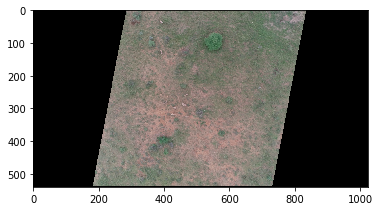

In [7]:
plt.imshow(outputs[-1][1])
print(outputs[0].shape)

In [21]:
import tensorflow as tf
sess = tf.InteractiveSession()
x = tf.constant([[[0,0,0],[0,0,0]],[[1,2,3],[4,5,6]]])
print(sess.run(tf.shape(x)))
print(sess.run((x))
y = tf.reshape(x, [2, 2,3])
print(sess.run(y))
sess.close()

[2 2 3]
[[[0 0 0]
  [0 0 0]]

 [[1 2 3]
  [4 5 6]]]
[[[0 0 0]
  [0 0 0]]

 [[1 2 3]
  [4 5 6]]]


/home/golden/.virtualenvs/coding-py35/lib/python3.5/site-packages/tensorflow/python/client/session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [13]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # "0, 1" for multiple

import tensorflow as tf
from keras import Input, Model
from keras import backend as K
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import MaxPool2D
from pose.models.layers import RegisterRotation2D, RegisterTranslation2D, Rotate2D, Translate2D
import matplotlib.pyplot as plt

In [14]:
tfrecord_folder = '/media/golden/72FFC6EE48B5CF39/drone-tracking/kenya-tracking/raw_frames_tf_records/scare_clips/'
tfrecord_clip_list = []
for index, walk_list in enumerate(os.walk(tfrecord_folder)):
    if index == 0:
        continue
    tfrecord_clip_list.append({'dirpath': walk_list[0],
                                'filenames': walk_list[2]})

clip_index = 0
tfrecord_list = [os.path.join(tfrecord_clip_list[clip_index]['dirpath'], filename) for filename in tfrecord_clip_list[clip_index]['filenames']][:1]
print('using ', len(tfrecord_list), 'files')
print('demo file:', tfrecord_list[0])

using  1 files
demo file: /media/golden/72FFC6EE48B5CF39/drone-tracking/kenya-tracking/raw_frames_tf_records/scare_clips/APR03_2018_C_DJI_0284/train-00000-of-00004


/home/golden/.virtualenvs/coding-py35/lib/python3.5/site-packages/tensorflow/python/client/session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


(270, 270)


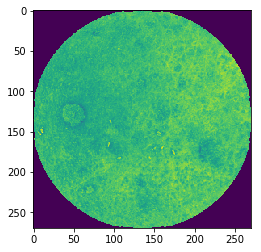

In [31]:
sess = tf.InteractiveSession()


dataset = tf.data.TFRecordDataset(tfrecord_list)

def _parse_tf_record(example_proto):

    raw_width = 4096
    raw_height = 2160
    downsampling = 8


    features = {
        'image/height': tf.FixedLenFeature((), tf.int64),
        'image/width': tf.FixedLenFeature((), tf.int64),
        'image/colorspace': tf.FixedLenFeature((), tf.string),
        'image/channels': tf.FixedLenFeature((), tf.int64),
        'image/format': tf.FixedLenFeature((), tf.string),
        'image/filename':tf.FixedLenFeature((), tf.string),
        'image/encoded': tf.FixedLenFeature([], tf.string)}
    parsed_features = tf.parse_single_example(example_proto, features)
    scale = parsed_features['image/width'] - parsed_features['image/height']
    x_crop = tf.cast(scale / (2 * downsampling), tf.int32)
    crop_window = tf.stack(
        [tf.constant(0, dtype=tf.int32), x_crop, tf.cast(2160/downsampling, tf.int32), 
         tf.cast(2160/downsampling, tf.int32)])
#     crop_window = tf.squeeze(crop_window)
#     crop_window = tf.constant([0,0,int(2160/downsampling),int(4096/downsampling)], dtype=tf.int32)

    image = tf.image.decode_and_crop_jpeg(
      parsed_features['image/encoded'], crop_window, channels=3, ratio=downsampling)
#     only use green channel
    image = image[:,:,1:2]
    image_shape = tf.shape(image)
    mask = np.zeros((int(raw_height/downsampling), int(raw_height/downsampling), 1), dtype=np.uint8)
    circle_middle = int(raw_height / downsampling / 2)
    mask = cv2.circle(mask, (circle_middle, circle_middle), 
                      circle_middle, 255, -1, lineType=cv2.LINE_AA)
    circle_mask = tf.constant(mask, dtype=tf.uint8)
    image = tf.where(tf.cast(circle_mask, tf.bool), image, circle_mask)

    return image
  # return (parsed_features['image/filename'])

batch = 1
dataset = dataset.map(_parse_tf_record, num_parallel_calls=2)
dataset = dataset.batch(batch)
dataset = dataset.prefetch(1)

# iterator = dataset.make_initializable_iterator()
iterator = dataset.make_one_shot_iterator()
next_image = iterator.get_next()
im = sess.run(next_image)
im = np.squeeze(im)
print(im.shape)
plt.imshow(im)
sess.close()